# Architecture of our ANN (Artificial Neural Network) / MLP (Multi Layer Perceptron) using GPU

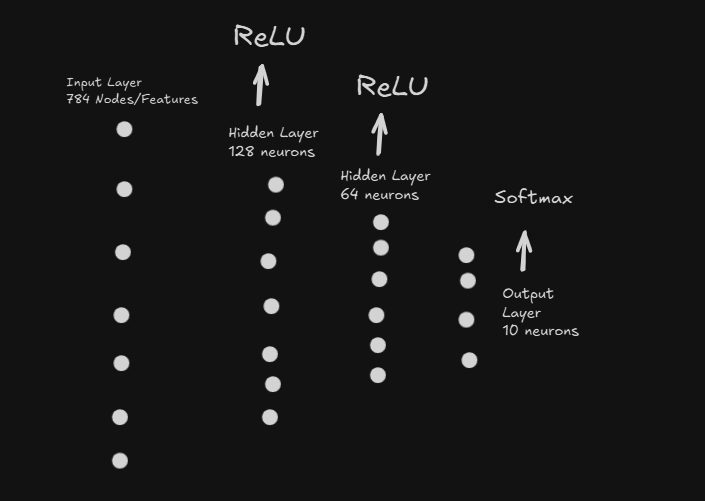

Model is looking at a 28x28 pixel image of clothing and predicting: "Which of the 10 fashion categories does this image most likely belong to?"

Using ReLU as AF for introducing Non-Linearity and Softmax to convert raw scores into clear probabilities that sum to 100%, so we can see exactly how confident the model is about each possible answer because this is multi class classification problem

For your Fashion MNIST: It turns numbers like `[5.2, 1.1, 0.3`] into percentages like `[78%, 15%, 7%]` so you know it's 78% sure it's seeing a T-shirt, not just "some big number."

The CSV stores images as flat lists of 784 numbers that you must reshape into 28x28 grids to actually see the pictures.


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [46]:
# Set random seeds for reproducibility so when you run second time you get same results
torch.manual_seed(42)

In [42]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [43]:
df = pd.read_csv('fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
df = df.dropna().reset_index(drop=True)

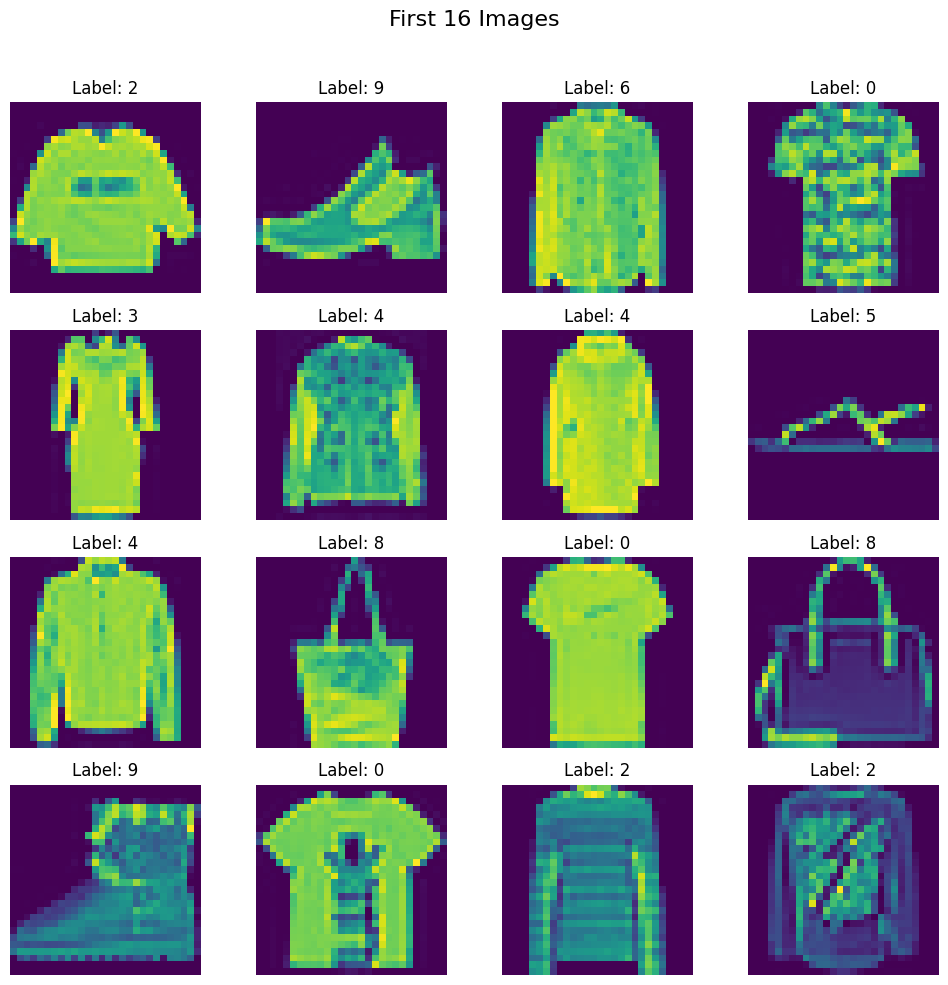

In [52]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [53]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Scaling the features (pixel values from 0-255 to 0-1)
X_train = X_train/255.0  # Normalize training data to range [0, 1]
X_test = X_test/255.0    # Normalize test data using same scaling

# Why we do this:
# 1. Neural networks train faster and more stably with small input values (0-1)
# 2. Prevents certain pixels from dominating others due to larger values
# 3. 255 is used because pixel values range from 0 to 255 (8-bit images)

In [47]:
X_train # We can now see every value is between 0 and 1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
# Create Custom Dataset Class
class FashionDataset(Dataset):

  def __init__(self, features, labels):
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    return self.features[idx], self.labels[idx]

In [58]:
# Create Train Dataset Object
train_dataset = FashionDataset(X_train, y_train)

In [59]:
len(train_dataset)

48000

In [32]:
train_dataset[0]

(tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.8447e-04,
         5.9977e-04, 0.0000e+00, 1.0765e-04, 1.8454e-04, 9.2272e-04, 4.6136e-05,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.0757e-05, 0.0000e+00, 1.0304e-03, 1.0304e-03, 1.1226e-03, 8.3045e-04,
         1.1073e-03, 9.6886e-04, 1.1073e-03, 1.4764e-03, 6.4591e-04, 0.0000e+00,
         3.0757e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.6136e-05, 0.0000e+00,
         7.3818e-04, 7.2280e-04, 4.1522e-04, 4.9212e-04, 0.0000e+00, 1.0765e-03,
         1.5379e-04, 1.3841e

In [60]:
# Create test_dataset object
test_dataset = FashionDataset(X_test, y_test)

In [61]:
# Create Train and Test Loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True) # Pin Memory will increase speed more in GPU by putting it directly in Pin Memory than Pager Memory
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True) # You dont usually do shuffling in prediction

## Model and Training

In [62]:
# Define NN Class
class MyNN(nn.Module):

  def __init__(self, num_features):

    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features, 128),  # Input layer to 128 neurons
        nn.ReLU(),                      # Activation function
        nn.Linear(128, 64),             # Hidden layer 128 to 64 neurons
        nn.ReLU(),                      # Activation function
        nn.Linear(64, 10)               # Output layer: 10 classes (raw logits)
        # Note we havent added Softmax here because later Cross Entropy Loss automatically adds it
    )

  def forward(self, x):

    return self.model(x)

In [63]:
# Set learning rate and epochs
epochs = 100
learning_rate = 0.1

In [64]:
# Instantiate the model - creates the neural network object
model = MyNN(X_train.shape[1])  # Input size = number of features (784 pixels)

# Moving model to GPU
model = model.to(device)

# Loss Function - measures how wrong the predictions are
criterion = nn.CrossEntropyLoss()  # Uses softmax internally + calculates loss

# Optimizer - updates model weights to reduce loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # Gradient descent optimizer

In [65]:
# Training loop - repeat for each epoch (full pass through dataset)
for epoch in range(epochs):

  total_epoch_loss = 0  # Track loss for this epoch

  # Process data in batches (mini-batch gradient descent)
  for batch_features, batch_labels in train_loader:

    # Move data to GPU
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # Forward pass - get model predictions
    outputs = model(batch_features)  # Model outputs raw scores (logits)

    # Calculate loss - compares predictions vs actual labels
    loss = criterion(outputs, batch_labels)  # Applies softmax + cross-entropy

    # Backward pass - calculate gradients
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute gradients via backpropagation

    # Update weights - improve model
    optimizer.step()       # Adjust weights using gradients

    # Accumulate loss for monitoring
    total_epoch_loss = total_epoch_loss + loss.item()

  # Calculate average loss for this epoch
  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')  # Track training progress

Epoch: 1 , Loss: 0.6475600895186265
Epoch: 2 , Loss: 0.4346417678544919
Epoch: 3 , Loss: 0.38751785828173163
Epoch: 4 , Loss: 0.36007626076539356
Epoch: 5 , Loss: 0.3367070125912627
Epoch: 6 , Loss: 0.3214337081188957
Epoch: 7 , Loss: 0.3069070008844137
Epoch: 8 , Loss: 0.2964548598850767
Epoch: 9 , Loss: 0.28651186083133023
Epoch: 10 , Loss: 0.2753435469418764
Epoch: 11 , Loss: 0.2670914305796226
Epoch: 12 , Loss: 0.259429781332612
Epoch: 13 , Loss: 0.2519795348321398
Epoch: 14 , Loss: 0.2439003275173406
Epoch: 15 , Loss: 0.23890515885005395
Epoch: 16 , Loss: 0.23112463180410364
Epoch: 17 , Loss: 0.2263457194690903
Epoch: 18 , Loss: 0.22176085958008965
Epoch: 19 , Loss: 0.21883239114222428
Epoch: 20 , Loss: 0.2134207928876082
Epoch: 21 , Loss: 0.205310202964892
Epoch: 22 , Loss: 0.2017811698826651
Epoch: 23 , Loss: 0.19750318689768512
Epoch: 24 , Loss: 0.1928066068875293
Epoch: 25 , Loss: 0.18932734179745117
Epoch: 26 , Loss: 0.18690977083767454
Epoch: 27 , Loss: 0.1818097959253937
Ep

## Evaluation

In Python, `_` is a throwaway variable name - it's convention for "I don't care about this value."

```python
# Let's say your model outputs these raw scores for 2 images:
outputs = torch.tensor([
    [1.2, 5.8, 0.3, 2.1],  # Image 1 scores for classes 0,1,2,3
    [0.9, 2.3, 4.1, 1.7]   # Image 2 scores for classes 0,1,2,3
])

# torch.max returns TWO things:
max_scores, predicted_classes = torch.max(outputs, 1)
print(max_scores)      # tensor([5.8, 4.1])   ← HOW confident
print(predicted_classes) # tensor([1, 2])     ← WHAT class
```

But for accuracy, we only care about WHAT not HOW:

```python
# We don't care if it was 90% confident or 51% confident
# We only care if it predicted the right class!

_, predicted = torch.max(outputs, 1)
# Now 'predicted' = [1, 2]  (class 1 and class 2)
# We threw away [5.8, 4.1] because we don't need confidence scores
```

In [66]:
# Set model to eval mode
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [67]:
# Evaluation code - test model performance on unseen data
total = 0      # Track total number of test samples
correct = 0    # Track number of correct predictions

with torch.no_grad():  # Disable gradient calculation for faster inference

  for batch_features, batch_labels in test_loader:

    # Move data to GPU
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # Get model predictions (raw logits)
    outputs = model(batch_features)

    # Convert outputs to class predictions
    # torch.max returns (max_values, max_indices) - we take the indices (class numbers)
    _, predicted = torch.max(outputs, 1)  # Get predicted class (0-9)

    # Update counters
    total = total + batch_labels.shape[0]  # Add batch size to total
    correct = correct + (predicted == batch_labels).sum().item()  # Count correct predictions

# Calculate final accuracy
print(correct/total)  # Output: Accuracy as decimal

0.8855


The weight update rule is:

`w_new = w_old - learning_rate * gradient`

So use `learning_rate` = `0.1`.